In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles

In [5]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [6]:
# function limit_func(param,pmin,pmax)
#     PL = pmax - pmin
#     offset = 0.5*(pmax + pmin)
#     PL/2 * (sin(pi * (param - offset)/PL) + 1) + pmin
# end
function limit_func(param,pmin,pmax)
    if pmin < param < pmax
        return param
    elseif param <= pmin
        return pmin
    else
        return pmax
    end
end

limit_func (generic function with 1 method)

In [34]:
#[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ] #I think the limit for Φ_ext is 0.96pi <-> 1.04pi
# p = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
p = [1.5, 5, 10, 0.95, 0.0, 1.51, 1/0.0271068, 0.995pi, 0.0]

function alpha(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ < t < Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [8]:
# Es, ψs = eigs(KinPot12 + p[4] .* get_Pot3(p[8]), nev=2, which=:SR)
# ω_qubit = real(Es[2] - Es[1])
# overlap_scale = abs(ψs[:,2]' * chargecoupling * ψs[:,1])

# ω_qubit, overlap_scale

In [9]:
function augmented_H_int!(du, u, p, t)
    H = KinPot12 + alpha(p, t) .* Potential3
    V = chargecoupling
    hamil = H + pulse(p, t) .* V
    
    a = transpose(reshape(u[1:2*NHilbert],NHilbert,2))
    ψT = reshape(u[2*NHilbert+1:4*NHilbert],NHilbert,2)
    # a = reshape(u[1:NHilbert],1,:)
    # ψT = u[NHilbert+1:2*NHilbert]

    du[1:2*NHilbert] = reshape(transpose(im .* a * hamil),:)
    du[2*NHilbert+1:4*NHilbert] = reshape(-im .* hamil * ψT,:)
    # du[1:NHilbert] = im .* a * hamil
    # du[NHilbert+1:2*NHilbert] = -im .* hamil * ψT
    
    du[4*NHilbert+1:end] = 2*real(im * tr(a * V * ψT)) .* dpulsedp(p, t) + 2*real(im * tr(a * Potential3 * ψT)) .* dalphadp(p,t)
    # du[2*NHilbert+1:end] = 2*real(im * a * V * ψT) .* dpulsedp(p, t, ω_qubit, overlap_scale) + 2*real(im * a * Potential3 * ψT) .* dalphadp(p,t)
end

augmented_H_int! (generic function with 1 method)

In [25]:
#buffer = [ω_qubit, overlap_scale, Potential3, ψ1s, ψT, counter]
# counter = 0
ps = []
ls = []

function H_int!(du, u, p, t)
    H = KinPot12 + alpha(p, t) .* Potential3
    V = pulse(p, t) .* chargecoupling
    du[:] = - im * (H + V) * u
end

E1s, ψ1s = eigs(KinPot12 + Potential3, nev=2, which=:SR)
# ψ1s
function calculate_common!(p, last_p, buffer)
    if p != last_p
        copy!(last_p, p)
        push!(ps,copy(last_p))
        buffer[6] += 1
        if buffer[6] % 100 == 0
            writedlm("tmp_ps.txt",ps)
            writedlm("tmp_ls.txt",ls)
        end
        # buffer[3] = get_Pot3(0.995pi)#p[8])
        # Es, ψs = eigs(KinPot12 + p[4] .* buffer[3], nev=2, which=:SR)
        # buffer[1] = real(Es[2] - Es[1])
        # buffer[2] = abs(ψs[:,2]' * chargecoupling * ψs[:,1])

        
        # T = 30.0#p[3] + 2*p[2]
        forward_prob = ODEProblem(H_int!, ψ1s[:,1:2], (0.0, 30.0), p)
        sol = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)
        buffer[5] = sol.u[end]
    end
end

function loss_func(buffer)
    UT = abs2.(ψ1s'*buffer[5])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end

function f(p, last_p, buffer)
    calculate_common!(p, last_p, buffer)
    loss = loss_func(buffer)
    push!(ls,copy(loss))
    return loss
end

function g!(storage, p, last_p, buffer)
    calculate_common!(p, last_p, buffer)
    ψT = buffer[5]
    a1 = - dropdims(ψT[:,1]'*ψ1s[:,2]*ψ1s[:,2]',dims=1)
    a2 = - dropdims(ψT[:,2]'*ψ1s[:,1]*ψ1s[:,1]',dims=1)

    u0_aug = cat(a1,a2,ψT[:,1],ψT[:,2],zeros(ComplexF64,length(p)),dims=1)
    # u0_aug = cat(a1,ψT[:,1],zeros(ComplexF64,length(p)),dims=1)
    aug_prob = ODEProblem(augmented_H_int!, u0_aug, (30.0,0.0), p)
    aug_sol = solve(aug_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)

    # push!(buffer,aug_sol)
    storage[:] = real(aug_sol.u[end][4*NHilbert+1:end])
    # storage[:] = real(aug_sol.u[end][2*NHilbert+1:end])
end

g! (generic function with 1 method)

In [26]:
initial_p = copy(p)
buffer = [nothing,nothing,nothing,nothing,zeros(ComplexF64,NHilbert,2),0]
last_p = similar(initial_p);

In [42]:
f(initial_p,last_p,buffer)

0.5887488418926403

In [43]:
storage = similar(last_p)
g!(storage,p,last_p,buffer)

9-element Vector{Float64}:
  0.09712024337521602
  0.09572689382624774
  0.0
 17.070639740102834
  0.1172924037917498
  1.9646593589766546
  0.03532592036057136
  0.0
 -0.07793557866655859

In [27]:
res = optimize(p -> f(p, initial_p, buffer),
               (storage, p) -> g!(storage, p, last_p, buffer),
               initial_p,BFGS())

 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     5.432586e-05

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.08e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.20e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.05e-08 ≰ 0.0e+00
    |g(x)|                 = 3.41e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   11903  (vs limit Inf)
    Iterations:    92
    f(x) calls:    404
    ∇f(x) calls:   404


In [28]:
Optim.minimizer(res)

9-element Vector{Float64}:
  1.3485473320123291
  5.169203455706284
 10.0
  0.6957013553333892
 -0.32780546612533923
  1.5221186508322737
 36.27197487910968
  3.1258846903218442
 -0.052823784639543764

In [29]:
# writedlm("tmp_ps.txt",ps)
# writedlm("tmp_ls.txt",ls)

In [30]:
p_new = copy(Optim.minimizer(res))

9-element Vector{Float64}:
  1.3485473320123291
  5.169203455706284
 10.0
  0.6957013553333892
 -0.32780546612533923
  1.5221186508322737
 36.27197487910968
  3.1258846903218442
 -0.052823784639543764

In [31]:
mask = ones(length(p_new))
mask[5] = 0
mask[6] = 0

0

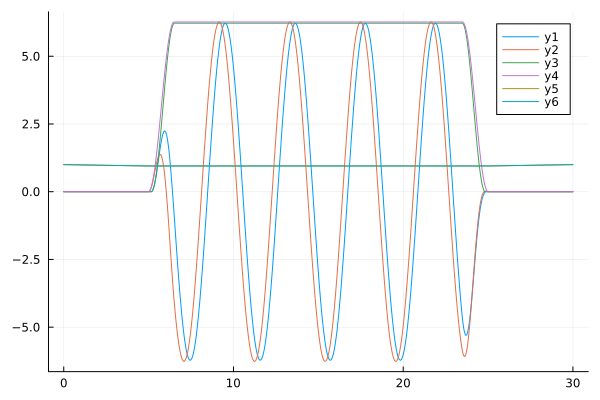

In [35]:
times = LinRange(0,30.0,500)

plot(times,[[pulse(p_new,t) for t in times],
            [pulse(p,t) for t in times],
            [pulse(p_new .* mask,t) for t in times],
            [pulse(p.*mask,t) for t in times],
            [alpha(p,t) for t in times],
            [alpha(p,t) for t in times]])

In [49]:
res

 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     5.432586e-05

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.12e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.08e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.20e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.05e-08 ≰ 0.0e+00
    |g(x)|                 = 3.41e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   11903  (vs limit Inf)
    Iterations:    92
    f(x) calls:    404
    ∇f(x) calls:   404


In [36]:
forward_prob = ODEProblem(H_int!, ψ1s, (0.0, 30.0), p_new)
sol_new = solve(forward_prob, p=p_new, saveat=LinRange(0,30.0,1000), reltol=1e-12, abstol=1e-15)

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float64}:
  0.0
  0.03003003003003003
  0.06006006006006006
  0.09009009009009009
  0.12012012012012012
  0.15015015015015015
  0.18018018018018017
  0.21021021021021022
  0.24024024024024024
  0.2702702702702703
  ⋮
 29.75975975975976
 29.78978978978979
 29.81981981981982
 29.84984984984985
 29.87987987987988
 29.90990990990991
 29.93993993993994
 29.96996996996997
 30.0
u: 1000-element Vector{Matrix{ComplexF64}}:
 [3.835480849665381e-11 - 7.448568444452389e-10im 5.919670547471689e-10 + 4.0373478021226716e-10im; -2.1635208373600882e-9 - 4.867871946156856e-9im 2.37965927760719e-9 + 4.578863147311388e-9im; … ; 2.6520736127120763e-9 - 4.6199030652284644e-9im 5.13155723935998e-9 + 5.439552438757918e-10im; 3.835485923058807e-11 - 7.448569196194522e-10im 5.919670104341769e-10 + 4.03734872812221e-10im]
 [4.988546731599798e-10 + 5.540932176328029e-10im -6.97059034257611e-10 + 1.6484282243840824e-10im; 4.967977448712537e-9

In [37]:
occs = zeros(Float64,1000,2,2)
# tmpPot3 = buffer[3]
for (i,t) in enumerate(sol_new.t)
    tmpEs, tmpψs = eigs(KinPot12 + alpha(p_new,t) .* Potential3, nev=2, which=:SR)
    occs[i,:,:] = abs2.(tmpψs'*sol_new.u[i])
end

In [38]:
zero = cat(occs[:,:,1],abs.(1 .- sum(occs,dims=2)[:,1,[1]]),dims=2)
one = cat(occs[:,:,2],abs.(1 .- sum(occs,dims=2)[:,1,[2]]),dims=2);

In [ ]:
# The optimized run:
# [Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
# 1.3485473320123291
# 5.169203455706284
# 10.0
# 0.6957013553333892
# -0.32780546612533923
# 1.5221186508322737
# 36.27197487910968
# 3.1258846903218442
# -0.052823784639543764

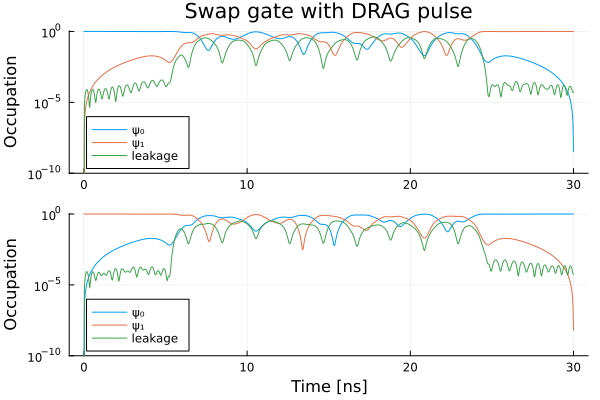

In [46]:
pzero = plot(sol_new.t,zero,title="Swap gate with DRAG pulse")
pone = plot(sol_new.t,one,xlabel="Time [ns]")

# plot(sol_new.t, [zero,one],yaxis=:log,ylims=(1e-10,1.1),layout=(2,1))
outputplot = plot(pzero,pone,
     layout=(2,1),
     yaxis=:log,
     ylims=(1e-10,1.1),
     legend=:bottomleft,
     label=["ψ₀" "ψ₁" "leakage"],
     ylabel="Occupation")

In [44]:
# 
UT = occs[end,:,:]
0.5 * (2 - UT[1,2] - UT[2,1])

5.422852099656872e-5

In [47]:
# savefig(outputplot,"Figures/SwapOptPulseAndAlpha2.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\JuliaStuff\\Figures\\SwapOptPulseAndAlpha2.pdf"

In [48]:
tmpEs, tmpψs = eigs(KinPot12 + Potential3, nev=10, which=:SR)
(abs2.(tmpψs'*sol_new.u[end]))

10×2 Matrix{Float64}:
 3.41985e-9  0.999945
 0.999947    6.20638e-9
 6.14343e-6  1.84828e-5
 9.55816e-6  2.05383e-6
 1.20276e-5  1.96376e-5
 2.30988e-5  1.33064e-5
 3.96923e-7  7.68583e-7
 1.16722e-6  1.05994e-7
 1.76384e-7  1.4717e-7
 3.33207e-7  3.01871e-7